In [1]:
!pip install psycopg2

In [12]:
import psycopg2

# データベース接続情報
host = 'postgis'
port = '5432'
user = 'postgres'
password = 'postgres'
database = 'sandbox'

# PostgreSQLに接続
conn = psycopg2.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# カーソルを作成
cur = conn.cursor()

# SQLクエリを実行
query = """
    SELECT p.id, p.name, p.name_en, p.geom
    FROM parks_akita_2023_07_18 AS p, flood_areas_akita_2023_07_19 AS f
    ORDER BY ST_Distance(ST_Transform(p.geom, 4326), ST_Transform(f.geometry, 4326)) DESC
    LIMIT 100;
"""
cur.execute(query)

# 結果を取得
results = cur.fetchall()

# 結果を表示
for row in results:
    print(row)

# カーソルと接続を閉じる
cur.close()
conn.close()


(587123511, '', '', '0103000020E61000000100000005000000D3A5DA025D7E6140FE710C12EC3544401B3B97985D7E6140617EB8F5E4354440AEEEFDB2607E614024D06053E73544406759411D607E614056838B70EE354440D3A5DA025D7E6140FE710C12EC354440')
(736887604, '三崎公園', '', '0103000020E610000001000000340000009BF4087F107C61406A334E43548F4340239CBB02F67B6140C77D50BC6F8F434000016BD5EE7B6140629346167A8F434078B306EFEB7B6140FDCDD5A0798F43407D299721E97B614094F540D0768F43405A457F68E67B6140F71B92FF6E8F43401DDD5218E57B6140ABB8CC446C8F43404D0B033BE37B6140D72F7D54688F4340905F8951E17B614030BDFDB9688F4340011E0714E07B614049C3842C668F4340FB5D3354E07B614010F1C5CD5F8F4340BF53B769E27B6140552646E0598F4340A0658286E37B61400D2950D54E8F4340E8B8BF1FE37B614040B15FC1478F434015BFCEF2E17B614001D479F9428F4340D81423A6DF7B614020741AB3368F4340733B4558DE7B614058E13BD6318F434077BF0AF0DD7B61403160C9552C8F434089A361E7DC7B61406F5C10DB278F4340D13E56F0DB7B6140E3433F09228F4340A8AED74FDA7B61401DF11AAA188F434013BBB6B7DB7B6140E96A86AF0A8F434081689C3CDB7B6140403

In [26]:
import geopandas as gpd
from shapely import wkb
import matplotlib.pyplot as plt


# 結果をgeopandasのGeoDataFrameに変換
gdf = gpd.GeoDataFrame(results, columns=['id', 'name', 'name_en', 'geom'])

# ジオメトリ列の形式を変換
gdf['geom'] = gdf['geom'].apply(lambda x: wkb.loads(x, hex=True))

# アクティブなジオメトリ列を設定
gdf.set_geometry('geom', inplace=True)

# 座標参照系（CRS）を設定
gdf.crs = 'EPSG:4326'

# 座標系の変換（日本測地系 → 緯度経度）
gdf = gdf.to_crs('EPSG:4326')

In [27]:
gdf.total_bounds

array([139.8696775,  39.1151196, 140.8438301,  40.4557434])

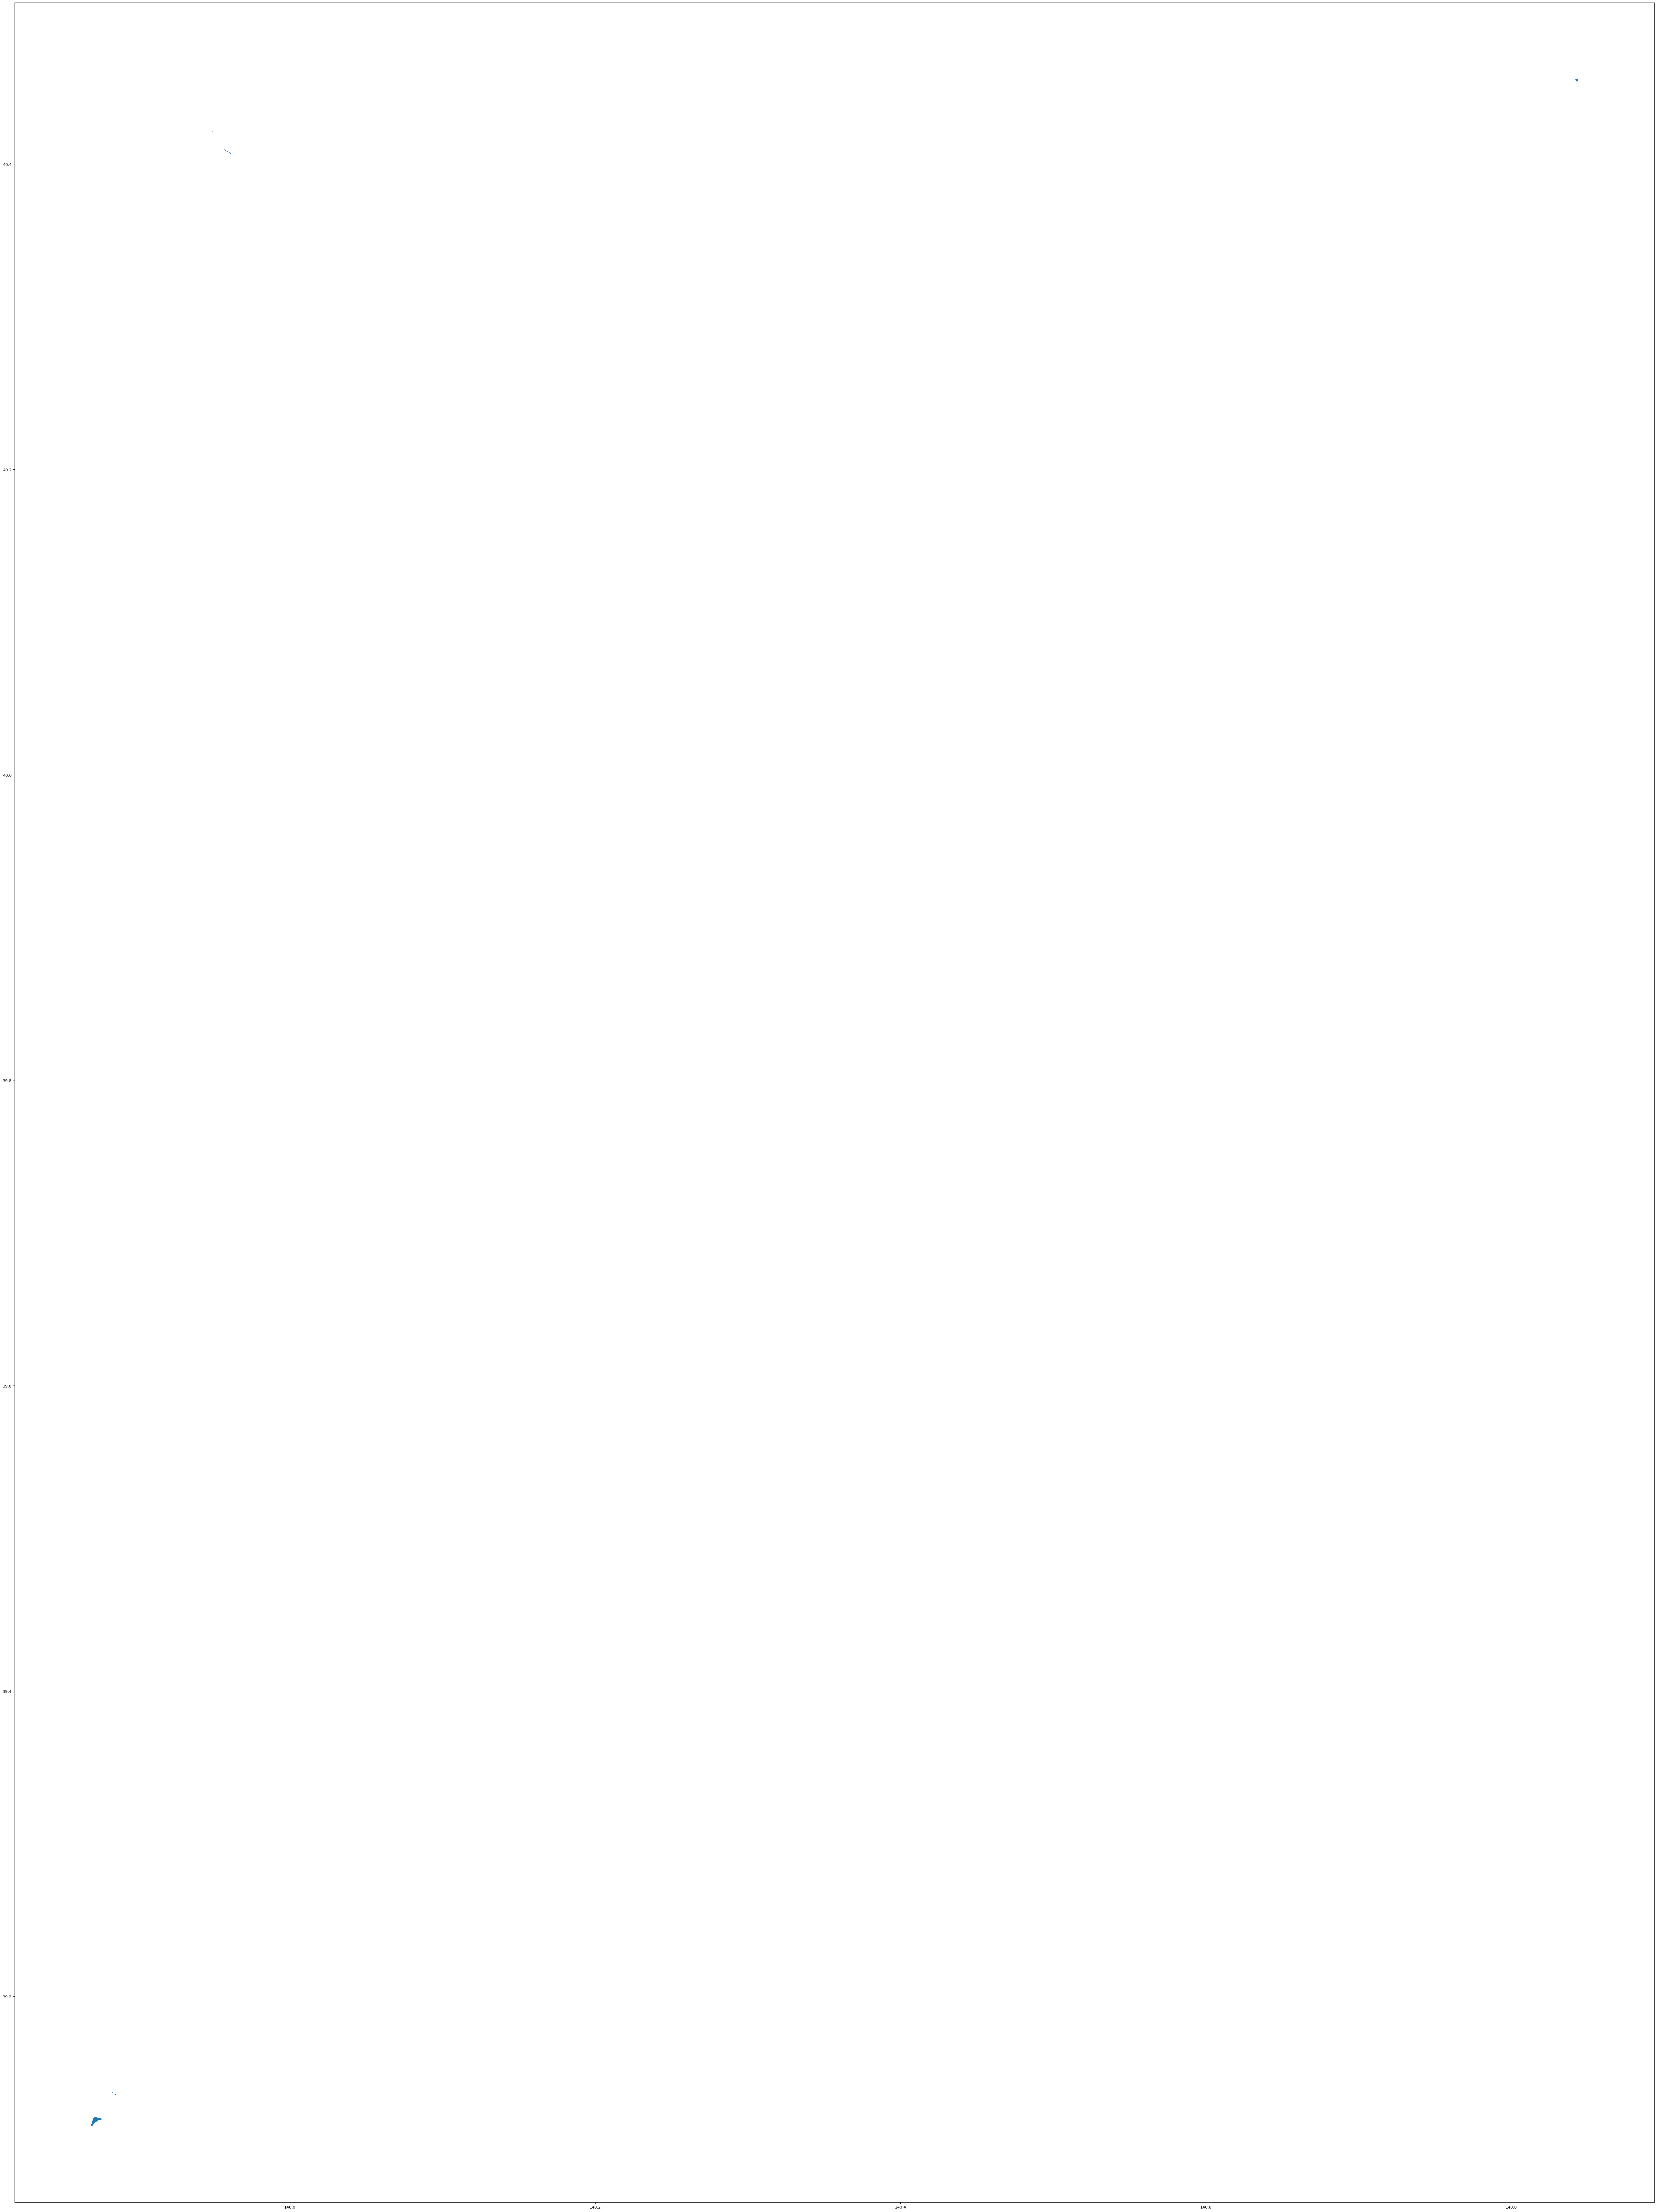

In [28]:

# 地図の表示
fig, ax = plt.subplots(figsize=(100, 100))
gdf.plot(ax=ax)
ax.set_aspect('equal')

# 秋田県にズーム
akita_bbox = gdf.total_bounds
padding = 0.05  # パディングを調整して適切な表示領域に合わせる
ax.set_xlim(akita_bbox[0] - padding, akita_bbox[2] + padding)
ax.set_ylim(akita_bbox[1] - padding, akita_bbox[3] + padding)

plt.show()